In [ ]:
# Import libraries and define scenario folder

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import scipy.io as scipyio
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
# Absolute path of the folder containing the units' folders and scenarioX.csv
scenario_folder = r'C:\Users\Baqer\Desktop\DeepSense6G Related\00 CNN Fusion Working Journal\Map-Drawing\Scenario31\scenario31'

In [3]:
# Automatically fetch CSV (the only csv in folder)
try:
    csv_file = [f for f in os.listdir(scenario_folder) if f.endswith('csv')][0]
    csv_path = os.path.join(scenario_folder, csv_file)
except:
    raise Exception(f'No csv file inside {scenario_folder}.')

dataframe = pd.read_csv(csv_path)
print(f'Columns: {dataframe.columns.values}')
print(f'Number of Rows: {dataframe.shape[0]}')

Columns: ['index' 'unit1_rgb' 'unit1_pwr_60ghz' 'unit1_lidar' 'unit1_radar'
 'unit1_loc' 'unit2_loc' 'unit1_beam' 'unit1_max_pwr' 'time_stamp'
 'seq_index' 'unit2_spd_over_grnd_kmph' 'unit2_num_sats' 'unit2_altitude'
 'unit2_geo_sep' 'unit2_mode_fix_type' 'unit2_pdop' 'unit2_hdop'
 'unit2_vdop' 'unit2_interpolated_position']
Number of Rows: 7012


In [13]:
N_BEAMS = 64
n_samples = 100

pwr_rel_paths = dataframe['unit1_pwr_60ghz'].values
pwrs_array = np.zeros((n_samples, N_BEAMS))

for sample_idx in tqdm(range(n_samples)):
    pwr_abs_path = os.path.join(scenario_folder, pwr_rel_paths[sample_idx])
    pwrs_array[sample_idx] = np.loadtxt(pwr_abs_path)

100%|██████████| 100/100 [00:00<00:00, 1784.53it/s]


In [ ]:
# GPS Data
# First, we fetch the GPS positions. 
# Then we prepare a satellite image on top of which we will plot the acquired positions and the respective reported indices for the best beam. 
# To compute the best beam in a given position, we find which beam index achived the highest power.

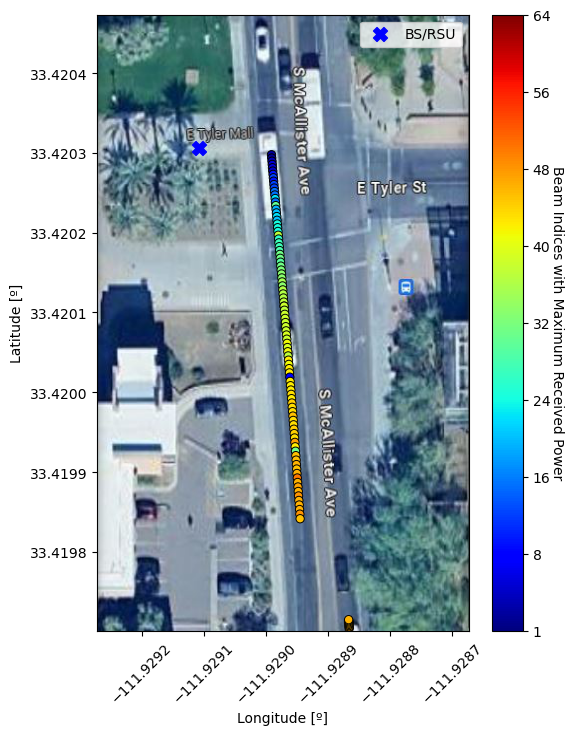

In [14]:
# BS: Receiver
bs_pos = np.loadtxt(os.path.join(scenario_folder, dataframe['unit1_loc'].values[0]))

# Transmitter Vehicle
pos_rel_paths = dataframe['unit2_loc'].values
pos_array = np.zeros((n_samples, 2)) # 2 = Latitude and Longitude

# Load each individual txt file
for sample_idx in range(n_samples):
    pos_abs_path = os.path.join(scenario_folder, pos_rel_paths[sample_idx])
    pos_array[sample_idx] = np.loadtxt(pos_abs_path)

# Display (additionally display the best beam for that position)

def deg_to_dec(d, m, s, direction='N'):
    if direction in ['N', 'E']:
        mult = 1
    elif direction in ['S', 'W']:
        mult = -1
    else:
        raise Exception('Invalid direction.')
        
    return mult * (d + m/60 + s/3600)

# We can take a screenshot from Google Map Satellite view and plot the positions on it
gps_img = plt.imread('31.JPG')
# GPS coordinates from the bottom left and top right coordinates of the screenshot
# https://www.gps-coordinates.net/
gps_bottom_left, gps_top_right = ((deg_to_dec(33, 25, 10.925, 'N'),
                                   deg_to_dec(111, 55, 45.38, 'W')),
                                  (deg_to_dec(33, 25, 13.704, 'N'),
                                   deg_to_dec(111, 55, 43.222, 'W')))

# Important: the screenshot was taken with the orientation towards North
best_beams = np.argmax(pwrs_array, axis=1)
fig, ax = plt.subplots(figsize=(6,8), dpi=100)
ax.imshow(gps_img, aspect='auto', zorder=0, 
          extent=[gps_bottom_left[1], gps_top_right[1],
                  gps_bottom_left[0], gps_top_right[0]])

scat = ax.scatter(pos_array[:,1], pos_array[:,0], edgecolor='black', lw=0.7,
                  c=(best_beams / N_BEAMS), vmin=0, vmax=1, 
                  cmap=matplotlib.colormaps['jet'])

cbar = plt.colorbar(scat)
cbar.set_ticks([0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1])
cbar.ax.set_yticklabels(['1', '8', '16', '24', '32', '40', '48', '56', '64'])
cbar.ax.set_ylabel('Beam Indices with Maximum Received Power', rotation=-90, labelpad=10)
ax.scatter(bs_pos[1], bs_pos[0], s=100, marker='X', color='blue', label='BS/RSU')
ax.legend()
ax.ticklabel_format(useOffset=False, style='plain')
ax.tick_params(axis='x', labelrotation=45)
ax.set_xlabel('Longitude [º]')
ax.set_ylabel('Latitude [º]')

# Saving all figures as a PDF file
output_filename = "Map_Top_Beams_31.pdf"
plt.savefig(output_filename, bbox_inches='tight', pad_inches=0.1)

# Show the plot
plt.show()